# Bayesian Model Comparison applied to COVID 19

- Author: Pablo Lemos (Sussex, UCL)
- Work in collaboration with Constantina Nicolaou, Ben Henghes and Ofer Lahav (UCL)

In this notebook, we demonstrate an application of the $\mathtt{cobaya}$ package to COVID 19 data. The package was developed for usage in cosmology, but can be use as a general tool for analysing data in a Bayesian framework. It can efficiently perform calculations such as finding the maximum of a posterior distribution, or sampling through Markov Chain Monte Carlo (MCMC) or Nested Sampling

This notebook was created for a demonstration in the workshop "Where Earth Meets the Sky", and as such it needs to be able to run in a short period of time. Therefore, it only runs a minimizer job with three parameters, and plots some chains that were run before. For more information, or help, please do get in touch! (p.lemos@sussex.ac.uk)

### Theory

All the authors are astrophysicists by training, and as a result we know next to nothing about biology, or how to model a pandemic. Our knowledge is based on what we found from reading papers, but if you spot any mistakes, do let us know!

We attempt to model the COVID 19 pandemic in the UK, through a simple epidemiological model. We use a combination of the SIRD and SIQR models. In our model, the population of the UK is divided between Susceptible, Infected, Recovered, Deceased and Quarantined. These populations evolve following these differential equations: 

\begin{eqnarray}
{dS \over dt} = - {\beta S I \over N} \\
{dI \over dt} = {\beta S I \over N}  - \gamma I - q I - \mu I \\
{dQ \over dt} = q I \\ 
{dR \over dt} = \gamma I + \gamma Q \\
{dD \over dt} = \mu I \\
\end{eqnarray}

Where $\beta, \gamma, \mu, q$ are the rates of infection, recovery, death and quarantine respectively. 

### Required packages

- Numpy
- Matplotlib
- Pandas
- Scipy
- Cobaya (https://cobaya.readthedocs.io/en/latest/)
- GetDist (https://getdist.readthedocs.io/en/latest/)

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

# To read the data
import pandas

# To integrate the SIR equations
from scipy.integrate import odeint

# To sample the posterior distribution
from cobaya.run import run
from cobaya.likelihood import Likelihood

# To plot the posterior distributions
from getdist.mcsamples import MCSamplesFromCobaya
import getdist.plots as gdplt

In [2]:
def read_data(path, country = 'United Kingdom', undo_cumulative = True):
    '''  Read the data file 

    Parameters:
    -----------
    path: str
      The path to the data file
    country: str
      The country which we want to read. Defaults to 'United Kingdom'

    Returns:
    --------
    data: nd.array
      The data extracted from the file
    firstcase: nd.array
      The index corresponding to the first non-zero element
   
    '''
    df = pandas.read_csv(path)

    # Extract specific country. The -1 keeps only the whole country, 
    # as opposed to just a region. The 4: keeps eliminates the entries
    # that are not part of the time series
    data = df[df['Country/Region'] == country].iloc[-1][4:]

    # Convert into a numpy array
    data = data.to_numpy()

    # The data is cummulative, undo that
    if undo_cumulative:
        data = data[1:] - data[:-1]
    else:
        data = data[:-1]

    # Find when first case occurs
    firstcase = np.where(data>0)[0][0]

    return data, firstcase

In [3]:
def integrate_SIR(S0, I0, Q0, R0, D0, ndays, beta, gamma, q, mu):
    ''' Integrate the SIR model equations
  
    Parameters:
    -----------
    S0, I0, R0: floats
      The initial values of S, I, R
    ndays: int
      The number of days over which to integratee
    beta, gamma: floats
      The parameters of the model

    Returns:
    --------
    S, I, R: nd.arrays
      The evolution of S, I, R over time

    '''

    # A grid of time points (in days)
    t = np.linspace(0, ndays, ndays)
    
    # Initial conditions vector
    y0 = S0, I0, Q0, R0, D0

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv_SIR, y0, t, args=(beta, gamma, q, mu))
    S, I, Q, R, D = ret.T
    return S, I, Q, R, D
    

In [4]:
def deriv_SIR(y, t, beta, gamma, q, mu):
    ''' The SIR model differential equations

    Parameters: 
    -----------
    y: tuple
      A tuplee containing S, I, R  the number of susceptible, infected
      and recovered respectively
    t: float
      Time
    beta, gamma: floats
      The parameters of the model

    Returns:
    --------
    dSdt, dIdt, dRdt: floats
      The derivatives of S, I, R with respect to time.
    '''
    
    # First lockdown
    if 55<=t<=136:
      qq = q
    elif 279<=t<=306:
      qq = q
    elif t>=341:
      qq = q
    else:
      qq = 0

    #qq = q*(np.exp(-(t-95.5)**2/2./(40.5/2)**2) + np.exp(-(t-292.5)**2/2./(15/2)**2) + np.exp(-(t-393)**2/2./(52/2)**2))

    S, I, Q, R, D = y
    
    # Total population 
    N = S + I + Q + R + D
    #beta /= N
    
    # Assume that the incubation period is the same quarantined or not
    gammap = gamma
    
    # From https://www.sciencedirect.com/science/article/pii/S2468042720300439
    # For COVID 19, qprime can be set to zero
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N  - gamma * I - qq*I - mu*I
    dQdt = qq * I - gammap*Q
    dRdt = gamma * I + gammap*Q
    dDdt = mu*I
    return dSdt, dIdt, dQdt, dRdt, dDdt



In [5]:
def logp_SIR(lbeta, lgamma, q, lmu):
    ''' 
    Calculate the log likelihood for the SIR model given parameters

    Parameters: 
    -----------
    beta, gamma: floats
      The parameters of the model

    Returns:
    --------
    logp: float
      The log likelihood (-2*chisq)
    '''
    beta = np.exp(lbeta)
    gamma = np.exp(lgamma)
    #q = np.exp(lq)
    mu = np.exp(lmu)
    
    _, I_theory, _, _, D_theory = integrate_SIR(S0, I0, Q0, R0, D0, ndays, beta, gamma, q, mu)
    
    I_theory = np.clip(I_theory, a_min = 1e-1, a_max = None)
    D_theory = np.clip(D_theory, a_min = 1e-1, a_max = None)
    pI = I_data*np.log((I_theory).astype(np.float32)) - I_theory - I_data.astype(np.float32)*np.log(I_data.astype(np.float32)) + I_data.astype(np.float32)
    pD = D_data*np.log((D_theory).astype(np.float32)) - D_theory - D_data.astype(np.float32)*np.log(D_data.astype(np.float32)) + D_data.astype(np.float32)
    return np.sum(pI+pD)

First, we read the UK data on infections and deaths (the data on recoveries is not reliable. The data does require some preprocessing: We eliminate all data before the first infection, as our theory only works once there is an infection. There are also some outliers in the infections data.

In [6]:
I_data, i_firstcase = read_data('../data/time_series_covid19_confirmed_global.csv', country = 'United Kingdom')
I_data = I_data[i_firstcase:]

D_data, _ = read_data('../data/time_series_covid19_deaths_global.csv', country = 'United Kingdom', undo_cumulative=False)
D_data = D_data[i_firstcase:]
D_data = np.clip(D_data, a_min = 1e-1, a_max = None)

# Correct two big outliers
I_data[152] = I_data[151]
I_data[153] = I_data[154]

# Total population, N.
N = 66.65*1e6 # Approximate population of the UK
# Number of days.
ndays = len(I_data)

# Initial number of infected and recovered individuals, I0 and R0.
I0, Q0, R0, D0 = I_data[0], 0, 0, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - Q0 - R0 - D0

Our data only measures new infections per day, but our model measures the infected population. Assuming each person is infected for 14 days, we can convert our data. 

In [7]:
# Each person is infected for approximately 14 days
Itot = np.zeros_like(I_data)
for i in range(ndays):
    if i<13: 
        Itot[i] = np.sum(I_data[:i+1])
    else:
        Itot[i] = np.sum(I_data[i-13:i+1])

I_data = Itot



Visualize the data

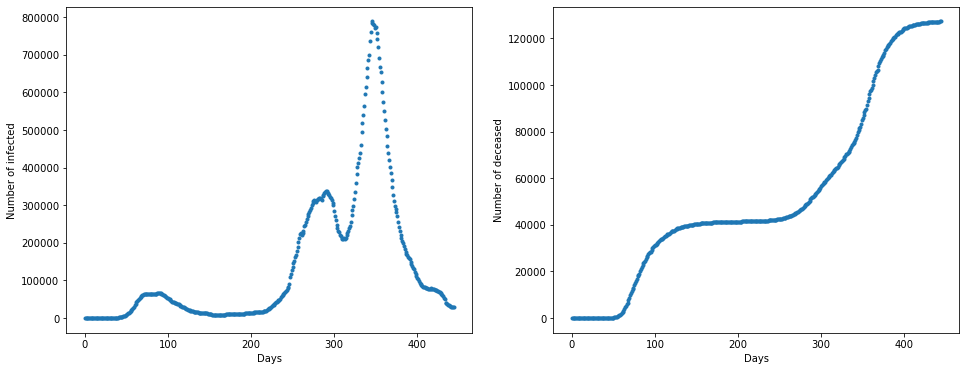

In [28]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols = 2, figsize = (16, 6))
ax1.plot(I_data, '.')
ax1.set_ylabel('Number of infected')
ax1.set_xlabel('Days')

ax2.plot(D_data, '.')
ax2.set_ylabel('Number of deceased')
ax2.set_xlabel('Days')

Now, we are going to use cobaya. For this, we are going to create a dictionary containing all necessary information.

First, tell cobaya what likelihood function we are using:

In [9]:
info = {"likelihood": {"covid": logp_SIR}}

For speed, I will set no quarantine (q = 0). The other parameters are run in log scale, i.e. the parameters are $\log \beta$, $\log \gamma$, $\log \mu$

In [20]:
info["params"] = {
    "lbeta": {"prior": {"min": -10, "max": 5}, "ref": -1.2},
    "lmu": {"prior": {"min": -10, "max": 0}, "ref": -5},
    "lgamma": {"prior": {"min": -10, "max": 5}, "ref": -1.2},
    "q": {"value": 0.},
}

I make $\beta, \gamma, \mu$ derived parameters, so without sampling them I also get information on them

In [21]:
info["params"]["beta"] = {"derived": lambda lbeta: np.exp(lbeta), "latex": r"\beta"}
info["params"]["mu"] = {"derived": lambda lmu: np.exp(lmu), "latex": r"\mu"}
info["params"]["gamma"] = {"derived": lambda lgamma: np.exp(lgamma), "latex": r"\gamma"}

I use the minimizer as my sampler. For a more complex sampler, I can use "mcmc" or "polychord"

In [22]:
info["sampler"] =  {"minimize": None}

In [23]:
updated_info, sampler = run(info)

[covid] Initialized external likelihood.
[minimize] Initializing
[minimize] Starting from random initial point:
[minimize] {'lbeta': -1.2, 'lmu': -5.0, 'lgamma': -1.2}
[prior] *WARNING* Reference pdf not defined or improper for some parameters. Using prior's sigma instead for them.
[minimize] Starting minimization.
[root] Function eval 1 at point 1 has f = 1024149495.30506 at x = [0. 0. 0.]
[root] Initialising (coordinate directions)
[root] Function eval 2 at point 2 has f = 1112918662.11041 at x = [0.1 0.  0. ]
[root] Function eval 3 at point 3 has f = 1057111926.0933 at x = [0.  0.1 0. ]
[root] Function eval 4 at point 4 has f = 1144230914.91469 at x = [0.  0.  0.1]
[root] Function eval 5 at point 5 has f = 1139982045.21576 at x = [-0.1  0.   0. ]
[root] Function eval 6 at point 6 has f = 994173123.938326 at x = [ 0.  -0.1  0. ]
[root] Function eval 7 at point 7 has f = 910571743.836383 at x = [ 0.   0.  -0.1]
[root] Beginning main loop
[root] Function eval 8 at point 8 has f = 19164

[root] Function eval 65 at point 65 has f = 585980609.127769 at x = [0.233669   0.50264938 0.20256817]
[root] Slow iteration (1 consecutive so far, max allowed 60)
[root] Function eval 66 at point 66 has f = 975805063.455266 at x = [0.23082998 0.47315844 0.18332987]
[root] Soft restart [currently, f = 5.85981e+08 after 66 function evals]
[root] Function eval 67 at point 67 has f = 132447367.238667 at x = [0.16935629 0.38521447 0.14333302]
[root] Function eval 68 at point 68 has f = 1110349602.01078 at x = [0.06282038 0.29696685 0.09539194]
[root] Function eval 69 at point 69 has f = 1564298857.79062 at x = [0.1108294  0.40173736 0.01015086]
[root] Function eval 70 at point 70 has f = 977110860.751079 at x = [0.2325999  0.4314601  0.18306917]
[root] New rho = 0.05 after 70 function evaluations
[root] Function eval 71 at point 71 has f = 1118613924.55026 at x = [0.09684958 0.39201778 0.15078046]
[root] Function eval 72 at point 72 has f = 1200040449.79058 at x = [0.20190849 0.35641753 0.

[root] Function eval 130 at point 130 has f = 861662905.637957 at x = [0.54411232 0.32647085 0.50916524]
[root] Function eval 131 at point 131 has f = 834515159.798695 at x = [0.67925989 0.42388553 0.67429971]
[root] New rho = 0.05 after 131 function evaluations
[root] Function eval 132 at point 132 has f = 857874957.915692 at x = [0.73337722 0.38153472 0.70434507]
[root] Function eval 133 at point 133 has f = 859424743.128946 at x = [0.73738676 0.43311862 0.72078645]
[root] Function eval 134 at point 134 has f = 1144231134.04664 at x = [0.65406923 0.41912973 0.71722771]
[root] Function eval 135 at point 135 has f = 882647491.886907 at x = [0.71353996 0.42525043 0.63792645]
[root] Soft restart [currently, f = 8.34515e+08 after 135 function evals]
[root] Function eval 136 at point 136 has f = 1008385452.02673 at x = [0.81269926 0.42193085 0.53229585]
[root] Function eval 137 at point 137 has f = 1246274667.9098 at x = [0.91036588 0.42048982 0.36367159]
[root] Function eval 138 at point 

[root] Function eval 196 at point 196 has f = 879079610.735441 at x = [1.07885467 0.06625703 0.62817074]
[root] New rho = 0.05 after 196 function evaluations
[root] Function eval 197 at point 197 has f = 860167106.239946 at x = [0.98371265 0.25787967 0.80141463]
[root] Slow iteration (1 consecutive so far, max allowed 60)
[root] Function eval 198 at point 198 has f = 858339352.063362 at x = [0.9855876  0.20874964 0.81050994]
[root] Slow iteration (2 consecutive so far, max allowed 60)
[root] Function eval 199 at point 199 has f = 859300931.344483 at x = [0.95511192 0.23125929 0.84313737]
[root] Soft restart [currently, f = 8.58339e+08 after 199 function evals]
[root] Function eval 200 at point 200 has f = 864505958.041409 at x = [0.88063203 0.50447647 0.80528533]
[root] Function eval 201 at point 201 has f = 1144231136.47794 at x = [0.77511075 0.5712298  1.09322036]
[root] Function eval 202 at point 202 has f = 857884754.156281 at x = [0.75922361 0.78644599 0.74008938]
[root] Function 

[root] Function eval 263 at point 263 has f = 861217695.033916 at x = [ 1.39631489 -0.15583926  0.83514068]
[root] New rho = 0.05 after 263 function evaluations
[root] Function eval 264 at point 264 has f = 856418908.047046 at x = [1.34955748 0.0389894  0.83044133]
[root] Function eval 265 at point 265 has f = 861506281.415646 at x = [ 1.33887262 -0.04896028  0.9114399 ]
[root] Function eval 266 at point 266 has f = 856378997.816408 at x = [1.30069167 0.0323894  0.82216049]
[root] Function eval 267 at point 267 has f = 856659863.536519 at x = [1.30154038 0.06381679 0.86103978]
[root] Soft restart [currently, f = 8.56379e+08 after 267 function evals]
[root] Function eval 268 at point 268 has f = 872959626.976918 at x = [ 1.19702776 -0.21344058  0.5007333 ]
[root] Function eval 269 at point 269 has f = 1035204843.81314 at x = [ 1.43182867 -0.25070805  0.15726032]
[root] Function eval 270 at point 270 has f = 879306025.086306 at x = [ 1.18307179 -0.62534206  0.43264198]
[root] Function ev

[root] Function eval 328 at point 328 has f = 864152794.398251 at x = [0.82934433 0.03552983 0.68624882]
[root] Function eval 329 at point 329 has f = 863330219.780201 at x = [ 0.82612443 -0.00130998  0.70708411]
[root] Function eval 330 at point 330 has f = 868002982.222801 at x = [0.92129729 0.01609954 0.7130932 ]
[root] Function eval 331 at point 331 has f = 862790283.009683 at x = [0.8904632  0.05907781 0.71841874]
[root] Soft restart [currently, f = 8.61987e+08 after 331 function evals]
[root] Function eval 332 at point 332 has f = 902342108.399923 at x = [1.43182867 0.23658256 0.58841303]
[root] Function eval 333 at point 333 has f = 3064129133.72532 at x = [1.43182867 0.62565723 0.11653981]
[root] Function eval 334 at point 334 has f = 888385169.471384 at x = [1.43182867 0.72704672 0.95377358]
[root] New rho = 0.05 after 334 function evaluations
[root] Function eval 335 at point 335 has f = 864536296.304582 at x = [1.43182867 0.47818844 0.91730495]
[root] Slow iteration (3 conse

## Comparison of different models

We now compare the following models: 

- No quarantine
- A single quarantine
- Three quarantine (following the timeline of when they really happened) modelled as step functions, all with the same height
- Same, but modelled as Gaussians, all of the same height

In [35]:
from getdist.mcsamples import loadMCSamples
import getdist.plots as gdplt

Load the chains

In [36]:
gdsamples_1 = loadMCSamples('../chains/simple', settings={'smooth_scale_2D':0.6, 'smooth_scale_1D':0.5})
#gdsamples_2 = loadMCSamples('../chains/quarantine_simple', settings={'smooth_scale_2D':0.6, 'smooth_scale_1D':0.5})
#gdsamples_3 = loadMCSamples('../chains/quarantine_step', settings={'smooth_scale_2D':0.6, 'smooth_scale_1D':0.5})
#gdsamples_4 = loadMCSamples('../chains/quarantine_gaussian', settings={'smooth_scale_2D':0.6, 'smooth_scale_1D':0.5})

[root] *WARNING* outlier fraction 0.15521978021978022 


Get the best fit for each

In [ ]:
bestfit1 = gdsamples_1.getParamBestFitDict(best_sample=True)
bestfit2 = gdsamples_2.getParamBestFitDict(best_sample=True)
bestfit3 = gdsamples_3.getParamBestFitDict(best_sample=True)
bestfit4 = gdsamples_4.getParamBestFitDict(best_sample=True)

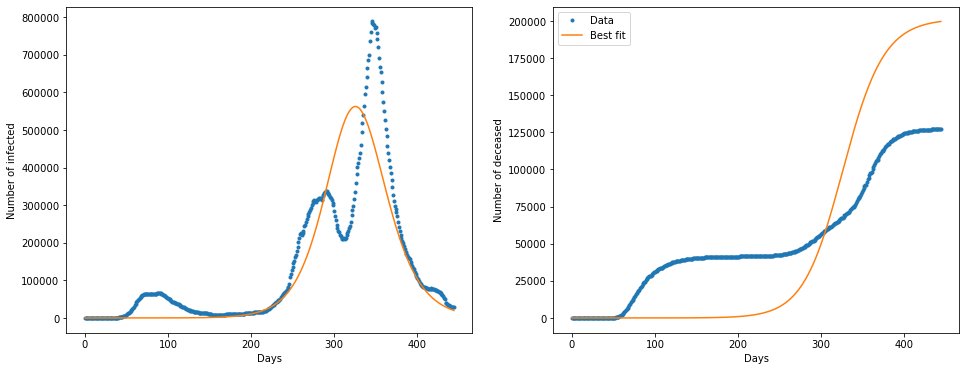

In [39]:
beta_bf = bestfit1['beta']
gamma_bf = bestfit1['gamma']
mu_bf = bestfit1['mu']
S_bf, I_bf, Q_bf, R_bf, D_bf = integrate_SIR(S0, I0, Q0, R0, D0, ndays, beta_bf, gamma_bf, q=0, mu=mu_bf)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols = 2, figsize = (16, 6))
ax1.plot(I_data, '.')
ax1.plot(I_bf)
ax1.set_ylabel('Number of infected')
ax1.set_xlabel('Days')

ax2.plot(D_data, '.', label = 'Data')
ax2.plot(D_bf, label = 'Best fit')
ax2.set_ylabel('Number of deceased')
ax2.set_xlabel('Days')
plt.legend()

In [ ]:
beta_bf = bestfit2['beta']
gamma_bf = bestfit2['gamma']
mu_bf = bestfit2['mu']
S_bf, I_bf, Q_bf, R_bf, D_bf = integrate_SIR(S0, I0, Q0, R0, D0, ndays, beta_bf, gamma_bf, q_bf, mu_bf)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols = 2, figsize = (16, 6))
ax1.plot(I_data, '.')
ax1.plot(I_bf)
ax1.set_ylabel('Number of infected')
ax1.set_xlabel('Days')

ax2.plot(D_data, '.', label = 'Data')
ax2.plot(D_bf, label = 'Best fit')
ax2.set_ylabel('Number of deceased')
ax2.set_xlabel('Days')
plt.legend()

| - | No quarantine | One quarantine | Step | Gaussian |
| --- | --- | --- | --- | --- |
| log R | 0.0 | 6.19 | 0.0 | 0.0 |

| Model 1 | Model 2 | Model 3 | Model 4 | 
| | | | 

- Model 1: -55084553.65976
- Model 2: -55084547.47

In [40]:
-55084547.47 +55084553.65976

6.189759999513626